# Import Necessary libraries

In [ ]:
!apt update && apt install -y cmake git curl

In [ ]:
!pip install pyngrok  # Required to expose FastAPI publicly

In [ ]:
!pip install fastapi uvicorn transformers huggingface_hub torch accelerate

In [ ]:
!git clone https://github.com/FasterDecoding/Medusa.git
%cd Medusa
!pip install -e .

In [ ]:
%cd ..

In [ ]:
!pip install pyngrok sentencepiece
# !pip install medusa-llm

In [ ]:
!git clone https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp


## Build LlamaCPP

In [ ]:
!cmake -B build
!cmake --build build --config Release -j 8

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


## clone Model form HF

In [ ]:
!git clone https://huggingface.co/lmsys/vicuna-7b-v1.3


In [ ]:
!cd .. && mkdir optimized_model

In [ ]:
!pwd

## convert to GGUF

In [ ]:
!python convert_hf_to_gguf.py vicuna-7b-v1.3 --outtype f16 --outfile ../optimized_model/vicuna-7b-v1.3-F16.gguf


In [ ]:
!cd ..

## Qauntize using llama CPP

In [ ]:
!cd /content/llama.cpp/build/bin && ./llama-quantize /content/optimized_model/vicuna-7b-v1.3-F16.gguf /content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf q4_K_M

In [ ]:
%cd /content/llama.cpp/vicuna-7b-v1.3/

## install python helper for llama cpp

In [4]:
!pip install llama-cpp-python==0.2.85

  Using cached llama_cpp_python-0.2.85.tar.gz (49.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.85-cp310-cp310-linux_x86_64.whl size=2873164 sha256=00443c2cf73398331ef51b22b7c0f952bc1e9fe53a4459631db430e9e5bea031
  Stored in directory: /root/.cache/pip/wheels/3f/e8/4e/29a754f9175ef52b6481cd75e3af4de38bf6dfa9c2972f75d4
Successfully built llama-cpp-python


In [5]:
from llama_cpp import Llama

In [ ]:
model_path = "/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf"

## load model for interfence testing

In [ ]:
llm = Llama(model_path=model_path)

### inference test 1

In [ ]:
generation_kwargs = {
    "max_tokens":200,
    "echo":False,
    "top_k":1
}

prompt = "Which country hosted 2018 fifa world cup?"
res = llm(prompt, **generation_kwargs)
res

### inference test 2

In [ ]:
generation_kwargs = {
    "max_tokens":200,
    "echo":False,
    "top_k":1
}

prompt = "who is MS dhoni?"
res = llm(prompt, **generation_kwargs)
res

### save quantized model to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir "/content/drive/My Drive/quantized_models"

In [ ]:
import shutil

source_file_path = '/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf'
destination_file_path = '/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf'

shutil.copy(source_file_path, destination_file_path)

In [ ]:
!pip install transformers==4.36.0 accelerate==0.25.0 huggingface_hub==0.20.0

In [ ]:
# import torch
# from llama_cpp import Llama
# from medusa.model.medusa_model import MedusaModel
# from transformers import LlamaConfig
# import numpy as np
# from typing import List, Optional, Dict
# import logging

# class MedusaLlamaCppModel:
#     def __init__(
#         self,
#         model_path: str = "/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf",
#         medusa_num_heads: int = 4,
#         device: str = "cuda" if torch.cuda.is_available() else "cpu",
#         n_ctx: int = 2048
#     ):
#         self.logger = logging.getLogger(__name__)
#         self.device = device

#         try:
#             # Initialize the base GGUF model
#             self.base_model = Llama(
#                 model_path=model_path,
#                 n_ctx=n_ctx,
#                 n_gpu_layers=-1  # Use GPU for all layers if available
#             )
#             self.logger.info("Base model loaded successfully")

#             # Initialize Medusa components
#             self.medusa_num_heads = medusa_num_heads
#             self.medusa_buffers = self._initialize_medusa_buffers()
#             self.logger.info("Medusa buffers initialized")

#         except Exception as e:
#             self.logger.error(f"Error initializing model: {str(e)}")
#             raise

#     def _initialize_medusa_buffers(self) -> Dict:
#         """Initialize Medusa buffers for speculative decoding"""
#         try:
#             # Create tree indices for Medusa heads
#             tree_indices = torch.zeros(
#                 (self.medusa_num_heads, 2),
#                 dtype=torch.long,
#                 device=self.device
#             )

#             # Create attention mask for Medusa heads
#             medusa_attn_mask = torch.ones(
#                 (self.medusa_num_heads + 1, self.medusa_num_heads + 1),
#                 dtype=torch.bool,
#                 device=self.device
#             )
#             medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)

#             # Create position IDs for Medusa
#             medusa_position_ids = torch.arange(
#                 self.medusa_num_heads,
#                 dtype=torch.long,
#                 device=self.device
#             )

#             return {
#                 "tree_indices": tree_indices,
#                 "medusa_attn_mask": medusa_attn_mask,
#                 "medusa_position_ids": medusa_position_ids,
#                 "retrieve_indices": None  # Will be set during generation
#             }
#         except Exception as e:
#             self.logger.error(f"Error initializing Medusa buffers: {str(e)}")
#             raise

#     def _speculative_decode(
#         self,
#         prompt: str,
#         temperature: float = 0.7,
#         posterior_threshold: float = 0.09,
#         posterior_alpha: float = 0.3
#     ) -> str:
#         """Perform speculative decoding with Medusa heads"""
#         try:
#             # Get base model prediction
#             base_output = self.base_model(
#                 prompt,
#                 max_tokens=1,
#                 temperature=temperature,
#                 echo=False
#             )
#             base_token = base_output['choices'][0]['text']

#             # Generate candidate continuations with Medusa heads
#             medusa_outputs = []
#             current_context = prompt + base_token

#             # Generate multiple candidates in parallel
#             for _ in range(self.medusa_num_heads):
#                 output = self.base_model(
#                     current_context,
#                     max_tokens=1,
#                     temperature=temperature,
#                     echo=False
#                 )
#                 medusa_outputs.append(output['choices'][0]['text'])

#             # If no valid candidates were generated, return base token
#             if not medusa_outputs:
#                 return base_token

#             # Calculate posterior probabilities
#             posterior_probs = self._calculate_posterior_probabilities(
#                 current_context,
#                 medusa_outputs,
#                 temperature,
#                 posterior_alpha
#             )

#             # Select best continuation based on posterior probabilities
#             best_idx = np.argmax(posterior_probs)
#             if posterior_probs[best_idx] >= posterior_threshold:
#                 return medusa_outputs[best_idx]
#             return base_token

#         except Exception as e:
#             self.logger.error(f"Error in speculative decoding: {str(e)}")
#             raise

#     def _calculate_posterior_probabilities(
#         self,
#         context: str,
#         candidates: List[str],
#         temperature: float,
#         alpha: float
#     ) -> np.ndarray:
#         """Calculate posterior probabilities for candidate tokens"""
#         try:
#             probs = []
#             for candidate in candidates:
#                 # Get probability of candidate given context
#                 output = self.base_model(
#                     context + candidate,
#                     max_tokens=0,
#                     temperature=temperature,
#                     echo=True
#                 )

#                 # Extract the log probability of the last token
#                 if 'logprobs' in output['choices'][0]:
#                     log_prob = output['choices'][0]['logprobs']['token_logprobs'][-1]
#                     prob = np.exp(log_prob)
#                 else:
#                     # Fallback if logprobs are not available
#                     prob = 1.0 / len(candidates)

#                 probs.append(prob)

#             # Apply temperature and alpha
#             probs = np.array(probs)
#             probs = probs ** (1 / temperature)
#             posterior = probs ** alpha

#             # Normalize
#             posterior = posterior / (np.sum(posterior) + 1e-10)

#             return posterior

#         except Exception as e:
#             self.logger.error(f"Error calculating posterior probabilities: {str(e)}")
#             raise

#     def generate(
#         self,
#         prompt: str,
#         max_tokens: int = 512,
#         temperature: float = 0.7,
#         posterior_threshold: float = 0.09,
#         posterior_alpha: float = 0.3
#     ) -> str:
#         """Generate text using Medusa-enhanced speculative decoding"""
#         try:
#             generated_text = prompt
#             tokens_generated = 0

#             while tokens_generated < max_tokens:
#                 next_token = self._speculative_decode(
#                     generated_text,
#                     temperature=temperature,
#                     posterior_threshold=posterior_threshold,
#                     posterior_alpha=posterior_alpha
#                 )

#                 if not next_token or next_token.strip() == "":
#                     break

#                 generated_text += next_token
#                 tokens_generated += 1

#                 # Log progress periodically
#                 if tokens_generated % 10 == 0:
#                     self.logger.info(f"Generated {tokens_generated} tokens")

#             return generated_text

#         except Exception as e:
#             self.logger.error(f"Error in text generation: {str(e)}")
#             raise

## without Medusa Head

In [ ]:
import torch
from llama_cpp import Llama
import numpy as np
from typing import List, Optional, Dict
import logging
from time import time

class MedusaLlamaCppModel:
    def __init__(
        self,
        model_path: str = "/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        n_ctx: int = 2048,
        n_batch: int = 512,  # Batch size for processing
        n_threads: int = 8    # Number of threads for parallel processing
    ):
        self.logger = logging.getLogger(__name__)
        self.device = device

        try:
            # Initialize the base GGUF model with optimized parameters
            self.base_model = Llama(
                model_path=model_path,
                n_ctx=n_ctx,
                n_batch=n_batch,      # Enable batch processing
                n_threads=n_threads,   # Enable multi-threading
                n_gpu_layers=-1,      # Use GPU for all layers if available
                verbose=False
            )
            self.logger.info("Base model loaded successfully")

            self.medusa_num_heads = medusa_num_heads
            self.batch_size = n_batch
            self.logger.info(f"Initialized with {medusa_num_heads} Medusa heads")

        except Exception as e:
            self.logger.error(f"Error initializing model: {str(e)}")
            raise

    def _batch_generate(
        self,
        prompt: str,
        n_tokens: int = 32,  # Generate multiple tokens at once
        temperature: float = 0.7
    ) -> str:
        """Generate multiple tokens in a single batch"""
        try:
            response = self.base_model(
                prompt,
                max_tokens=n_tokens,
                temperature=temperature,
                echo=False,
                stop=["</s>", "<|endoftext|>"]
            )

            if isinstance(response, dict) and 'choices' in response:
                return response['choices'][0]['text']
            elif isinstance(response, list) and len(response) > 0:
                return response[0]['text']
            return ""

        except Exception as e:
            self.logger.error(f"Error in batch generation: {str(e)}")
            return ""

    def generate(
        self,
        prompt: str,
        max_tokens: int = 512,
        temperature: float = 0.7,
        batch_size: int = 32  # Number of tokens to generate per batch
    ) -> str:
        """Generate text using optimized batch processing"""
        try:
            generated_text = prompt
            tokens_generated = 0
            start_time = time()

            self.logger.info(f"Starting generation with prompt: {prompt[:50]}...")

            while tokens_generated < max_tokens:
                # Calculate remaining tokens
                remaining_tokens = max_tokens - tokens_generated
                current_batch_size = min(batch_size, remaining_tokens)

                # Generate batch of tokens
                new_text = self._batch_generate(
                    generated_text,
                    n_tokens=current_batch_size,
                    temperature=temperature
                )

                if not new_text:
                    break

                generated_text += new_text
                tokens_generated += len(new_text.split())  # Approximate token count

                # Log progress with speed metrics
                if tokens_generated % 50 == 0:
                    elapsed_time = time() - start_time
                    speed = tokens_generated / elapsed_time
                    self.logger.info(f"Generated {tokens_generated} tokens. Speed: {speed:.2f} tokens/second")

            # Final statistics
            total_time = time() - start_time
            avg_speed = tokens_generated / total_time
            self.logger.info(f"Generation completed. Total tokens: {tokens_generated}")
            self.logger.info(f"Average speed: {avg_speed:.2f} tokens/second")

            return generated_text

        except Exception as e:
            self.logger.error(f"Error in text generation: {str(e)}")
            return generated_text  # Return what we have so far

def print_generation_stats(text: str, time_taken: float):
    """Print generation statistics"""
    tokens = len(text.split())
    speed = tokens / time_taken
    print(f"\nGeneration Statistics:")
    print(f"Total tokens: {tokens}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Speed: {speed:.2f} tokens/second")

In [ ]:
model = MedusaLlamaCppModel(
    model_path="/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf",
    medusa_num_heads=4,
    n_batch=512,      # Increased batch size
    n_threads=8
)

# Generate text


In [ ]:
prompt = "Once upon a time"
start_time = time()

generated_text = model.generate(
    prompt=prompt,
    max_tokens=100,
    temperature=0.7,
    batch_size=32     # Adjust based on your GPU memory
)

end_time = time()

# Print results and statistics
print("\nGenerated text:")
print(generated_text)
print_generation_stats(generated_text, end_time - start_time)

## With Medusa Head

### with medusa head not working code

In [ ]:
import torch
from llama_cpp import Llama
import numpy as np
from typing import List, Dict, Tuple
import logging
from time import time

class MedusaLlamaCppModel:
    def __init__(
        self,
        model_path: str = "/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        n_ctx: int = 2048,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger(__name__)
        self.device = device
        self.medusa_num_heads = medusa_num_heads

        try:
            # Initialize the base model
            self.base_model = Llama(
                model_path=model_path,
                n_ctx=n_ctx,
                n_threads=n_threads,
                n_gpu_layers=-1,
                verbose=False
            )
            self.logger.info("Base model loaded successfully")

        except Exception as e:
            self.logger.error(f"Error initializing model: {str(e)}")
            raise

    def _generate_medusa_candidates(
        self,
        context: str,
        temperature: float = 0.7
    ) -> Tuple[str, List[str]]:
        """
        Generate the next token and Medusa head predictions
        Returns: (base_prediction, medusa_predictions)
        """
        try:
            # Get base model prediction first
            base_response = self.base_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )
            base_prediction = base_response['choices'][0]['text'] if base_response else ""

            # Generate Medusa head predictions in parallel
            medusa_predictions = []
            medusa_context = context + base_prediction

            # Each Medusa head tries to predict the next token after the base prediction
            for _ in range(self.medusa_num_heads):
                medusa_response = self.base_model(
                    medusa_context,
                    max_tokens=1,
                    temperature=temperature * 1.1,  # Slightly higher temperature for diversity
                    echo=False
                )
                if medusa_response:
                    medusa_predictions.append(medusa_response['choices'][0]['text'])

            return base_prediction, medusa_predictions

        except Exception as e:
            self.logger.error(f"Error in Medusa candidate generation: {str(e)}")
            return "", []

    def _verify_predictions(
        self,
        context: str,
        base_prediction: str,
        medusa_predictions: List[str],
        temperature: float = 0.7,
        threshold: float = 0.09
    ) -> str:
        """
        Verify Medusa predictions against base model prediction
        Returns the accepted prediction
        """
        try:
            # If no Medusa predictions, return base prediction
            if not medusa_predictions:
                return base_prediction

            # Score each prediction including base prediction
            all_predictions = [base_prediction] + medusa_predictions
            scores = []

            for pred in all_predictions:
                # Get model's confidence score for this prediction
                response = self.base_model(
                    context + pred,
                    max_tokens=0,
                    temperature=0,  # Use temperature 0 for scoring
                    echo=True
                )

                # Extract score from response
                if response and 'choices' in response:
                    score = float(response['choices'][0].get('score', 0))
                    scores.append(score)
                else:
                    scores.append(0.0)

            # Convert scores to probabilities
            scores = np.array(scores)
            probs = np.exp(scores - np.max(scores))
            probs = probs / np.sum(probs)

            # Select best prediction if it meets threshold
            best_idx = np.argmax(probs)
            if probs[best_idx] >= threshold:
                return all_predictions[best_idx]

            return base_prediction

        except Exception as e:
            self.logger.error(f"Error in prediction verification: {str(e)}")
            return base_prediction

    def generate(
        self,
        prompt: str,
        max_tokens: int = 512,
        temperature: float = 0.7,
        threshold: float = 0.09
    ) -> str:
        """Generate text using true Medusa-style speculative decoding"""
        try:
            generated_text = prompt
            tokens_generated = 0
            start_time = time()
            accepted_speculative = 0  # Counter for accepted speculative tokens

            self.logger.info(f"Starting generation with Medusa heads: {self.medusa_num_heads}")

            while tokens_generated < max_tokens:
                # Generate base and Medusa predictions
                base_pred, medusa_preds = self._generate_medusa_candidates(
                    generated_text,
                    temperature
                )

                if not base_pred:
                    break

                # Verify predictions
                accepted_token = self._verify_predictions(
                    generated_text,
                    base_pred,
                    medusa_preds,
                    temperature,
                    threshold
                )

                # Update statistics
                if accepted_token in medusa_preds:
                    accepted_speculative += 1

                generated_text += accepted_token
                tokens_generated += 1

                # Log progress with Medusa statistics
                if tokens_generated % 10 == 0:
                    elapsed_time = time() - start_time
                    speed = tokens_generated / elapsed_time
                    speculative_ratio = (accepted_speculative / tokens_generated) * 100
                    self.logger.info(
                        f"Generated {tokens_generated} tokens. "
                        f"Speed: {speed:.2f} tokens/second. "
                        f"Speculative acceptance: {speculative_ratio:.1f}%"
                    )

            # Final statistics
            total_time = time() - start_time
            avg_speed = tokens_generated / total_time
            final_speculative_ratio = (accepted_speculative / tokens_generated) * 100

            self.logger.info(
                f"\nGeneration completed:"
                f"\n- Total tokens: {tokens_generated}"
                f"\n- Average speed: {avg_speed:.2f} tokens/second"
                f"\n- Speculative acceptance rate: {final_speculative_ratio:.1f}%"
            )

            return generated_text

        except Exception as e:
            self.logger.error(f"Error in text generation: {str(e)}")
            return generated_text

In [ ]:
# model = MedusaLlamaCppModel(
#     model_path="/content/optimized_model/vicuna-7b-v1.3-F16_KM.gguf",
#     medusa_num_heads=4,
#     n_threads=16
# )

# # Generate text
# prompt = "Once upon a time"
# generated_text = model.generate(
#     prompt=prompt,
#     max_tokens=50,
#     temperature=0.7,
#     threshold=0.09
# )

# print("\nGenerated text:")
# print(generated_text)

### with medusa head working code a bit

In [ ]:
import torch
import numpy as np
import time
from llama_cpp import Llama
from typing import List, Dict, Tuple, Optional
import logging
from dataclasses import dataclass
import os

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

@dataclass
class MedusaConfig:
    """Configuration for Medusa head."""
    num_heads: int = 4
    max_tokens: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3
    tree_branching_factor: int = 2
    draft_checkpoint_ratio: float = 0.5

class MedusaHead:
    """Implementation of Medusa head for speculative decoding."""

    def __init__(self, num_heads: int):
        self.logger = logging.getLogger("MedusaHead")
        self.num_heads = num_heads
        self.logger.info(f"Initialized Medusa head with {num_heads} heads")

        self.tree_indices = self._create_tree_indices()
        print(f"Tree Indices: {self.tree_indices}")

    def _create_tree_indices(self) -> List[List[int]]:
        """Create tree indices for heads."""
        tree = []
        for i in range(self.num_heads):
            level = []
            for j in range(min(2**i, self.num_heads - len(tree))):
                level.append(i + j)
            if level:
                tree.append(level)
        self.logger.info(f"Tree indices created: {tree}")
        return tree

    def generate_draft_tokens(self, model: Llama, prompt: str, temperature: float) -> List[str]:
        """Generate draft tokens using the tree structure."""
        base_token = self._generate_token(model, prompt, temperature)
        print(f"Base Token: {base_token}")
        if not base_token:
            return []

        draft_sequence = [base_token]
        current_prompt = prompt + base_token

        for level in self.tree_indices:
            if not current_prompt:
                break

            level_tokens = []
            for _ in level:
                token = self._generate_token(model, current_prompt, temperature)
                print(f"Generated Token at Level {level}: {token}")
                if token:
                    level_tokens.append(token)

            if not level_tokens:
                break

            draft_sequence.append(level_tokens[0])
            current_prompt += level_tokens[0]

        print(f"Final Draft Sequence: {draft_sequence}")
        return draft_sequence

    def _generate_token(self, model: Llama, prompt: str, temperature: float) -> str:
        """Generate a single token from the model."""
        try:
            response = model(
                prompt,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )
            print(f"Model Response: {response}")
            if isinstance(response, dict) and 'choices' in response:
                return response['choices'][0]['text']
            elif isinstance(response, list) and len(response) > 0:
                return response[0]['text']
            return ""
        except Exception as e:
            self.logger.error(f"Error generating token: {str(e)}")
            return ""

class MedusaModel:
    """Main Medusa model combining llama.cpp with Medusa head."""

    def __init__(self, model_path: str, config: Optional[MedusaConfig] = None):
        self.logger = logging.getLogger("MedusaModel")
        self.config = config or MedusaConfig()

        try:
            self.logger.info(f"Loading model from {model_path}")
            self.base_model = Llama(
                model_path=model_path,
                n_ctx=4096,
                n_batch=512,
                n_threads=8,
                n_gpu_layers=-1,
                verbose=False
            )
            self.logger.info("Base model loaded successfully")

            self.medusa_head = MedusaHead(self.config.num_heads)
            self.logger.info(f"Medusa head initialized with {self.config.num_heads} heads")

        except Exception as e:
            self.logger.error(f"Error initializing model: {str(e)}")
            raise

    def generate(self, prompt: str, config: Optional[MedusaConfig] = None) -> Dict:
        """Generate text using Medusa speculative decoding."""
        cfg = config or self.config
        self.logger.info(f"Generating text with Medusa ({cfg.num_heads} heads)")

        generated_text = prompt
        tokens_generated = 0
        tokens_accepted = 0
        draft_tokens_generated = 0
        iterations = 0
        speedup = 0.0

        start_time = time.time()
        baseline_tokens_per_sec = 0

        warmup_tokens = min(20, cfg.max_tokens // 10)
        warmup_start = time.time()
        warmup_text = "WARMUP TEXT HERE"
        warmup_time = time.time() - warmup_start
        if warmup_tokens > 0 and warmup_time > 0:
            baseline_tokens_per_sec = warmup_tokens / warmup_time
            print(f"Baseline Speed: {baseline_tokens_per_sec:.2f} tokens/sec")

        while tokens_generated < cfg.max_tokens:
            iterations += 1

            draft_start = time.time()
            drafts = self.medusa_head.generate_draft_tokens(
                self.base_model, generated_text, cfg.temperature
            )
            draft_time = time.time() - draft_start
            print(f"Draft Tokens: {drafts}")

            draft_tokens_generated += len(drafts)

            if not drafts:
                token = "FALLBACK TOKEN"
                generated_text += token
                tokens_generated += 1
                print(f"Fallback Token: {token}")
                continue

            verify_start = time.time()
            accepted_count, probs = (len(drafts), [0.9] * len(drafts))
            verify_time = time.time() - verify_start

            if accepted_count > 0:
                accepted_drafts = drafts[:accepted_count]
                generated_text += ''.join(accepted_drafts)
                tokens_generated += accepted_count
                tokens_accepted += accepted_count
                print(f"Accepted Tokens: {accepted_drafts}")
                for token in accepted_drafts:
                    print(token, end="", flush=True)
            else:
                token = "FALLBACK TOKEN"
                generated_text += token
                tokens_generated += 1
                print(f"Generated Token: {token}")

            if tokens_generated % 10 == 0:
                elapsed = time.time() - start_time
                current_speed = tokens_generated / elapsed if elapsed > 0 else 0
                if baseline_tokens_per_sec > 0:
                    speedup = current_speed / baseline_tokens_per_sec
                print(f"Tokens Generated: {tokens_generated}, Speed: {current_speed:.2f} tokens/sec, Speedup: {speedup:.2f}")

        total_time = time.time() - start_time
        tokens_per_sec = tokens_generated / total_time if total_time > 0 else 0
        acceptance_rate = tokens_accepted / draft_tokens_generated * 100 if draft_tokens_generated > 0 else 0

        print(f"Final Stats -> Tokens Generated: {tokens_generated}, Speed: {tokens_per_sec:.2f} tokens/sec, Acceptance Rate: {acceptance_rate:.1f}%")

        return {
            "tokens_generated": tokens_generated,
            "draft_tokens_generated": draft_tokens_generated,
            "tokens_per_sec": tokens_per_sec,
            "acceptance_rate": acceptance_rate
        }


In [ ]:
# Initialize the Medusa model with your GGUF model
medusa_config = MedusaConfig(
    num_heads=4,                # Number of Medusa heads
    max_tokens=50,             # Maximum tokens to generate
    temperature=0.7,            # Temperature for generation
    posterior_threshold=0.09,   # Threshold for accepting draft tokens
    posterior_alpha=0.3         # Alpha for posterior scaling
)

model = MedusaModel(
    model_path="/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
    config=medusa_config
)

# Generate text with Medusa speculative decoding
prompt = "there was a cricketer named MS dhoni"
result = model.generate(prompt)
# generated_text = result["choices"][0]["text"]
# Print the generated text
print("\nGenerated Text:")
print(result)

# Print performance statistics
# stats = result["stats"]
# print(f"\nPerformance Statistics:")
# print(f"- Tokens generated: {stats['tokens_generated']}")
# print(f"- Generation speed: {stats['tokens_per_sec']:.2f} tokens/second")
# print(f"- Speedup: {stats['speedup']:.2f}x faster than standard generation")
# print(f"- Acceptance rate: {stats['acceptance_rate']:.1f}%")

### medusa working code 3 not working

In [ ]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException, BackgroundTasks
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63  # Pre-defined Medusa choices
from medusa.model.utils import generate_medusa_buffers, reset_medusa_mode, initialize_medusa
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

@dataclass
class BatchRequest:
    id: str
    prompt: str
    timestamp: datetime
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding
    """
    def __init__(
        self,
        model_path: str = "/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Load compiled model
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_choices = mc_sim_7b_63
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa with {medusa_num_heads} heads")

        # Baseline metrics for speedup calculation
        self._baseline_tokens_per_second = self._calculate_baseline_speed()

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding"""
        # Create buffers similar to how the Medusa model does it
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa"""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding with llama.cpp backend"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()

            # Initial generation
            input_text = prompt
            generated_text = ""
            tokens_generated = 0
            draft_tokens_generated = 0
            accepted_tokens = 0

            while tokens_generated < max_length:
                # Generate base prediction and drafts
                base_token, drafts = self._generate_drafts(input_text, temperature)

                if not base_token:
                    break

                # Verify drafts
                accepted_count, accepted_drafts = self._verify_drafts(
                    input_text,
                    [base_token] + drafts,
                    temperature,
                    posterior_threshold,
                    posterior_alpha
                )

                # Update counts and text
                draft_tokens_generated += len(drafts) + 1  # base + drafts
                accepted_tokens += accepted_count

                if accepted_count > 0:
                    accepted_text = ''.join(accepted_drafts)
                    input_text += accepted_text
                    generated_text += accepted_text
                    tokens_generated += accepted_count
                else:
                    # If no drafts accepted, use base token
                    input_text += base_token
                    generated_text += base_token
                    tokens_generated += 1

                # Check for generation completion
                if tokens_generated % 50 == 0:
                    self.logger.info(f"Generated {tokens_generated} tokens")

            # Calculate statistics
            elapsed_time = time.time() - start_time
            tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
            speedup = tokens_per_second / self._baseline_tokens_per_second

            return {
                "text": generated_text,
                "generation_time": elapsed_time,
                "tokens_generated": tokens_generated,
                "tokens_per_second": tokens_per_second,
                "speedup_factor": speedup,
                "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
            }

    def _generate_drafts(self, context: str, temperature: float):
        """Generate base token and draft tokens using Medusa tree structure"""
        try:
            # Generate base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )

            if not base_response or 'choices' not in base_response:
                return "", []

            base_token = base_response['choices'][0]['text']

            # Generate draft tokens following the Medusa tree structure
            drafts = []
            draft_context = context + base_token

            for _ in range(self.medusa_num_heads - 1):  # -1 because we already have the base token
                draft_response = self.llama_model(
                    draft_context,
                    max_tokens=1,
                    temperature=temperature,
                    echo=False
                )

                if draft_response and 'choices' in draft_response:
                    draft_token = draft_response['choices'][0]['text']
                    drafts.append(draft_token)
                    draft_context += draft_token
                else:
                    break

            return base_token, drafts

        except Exception as e:
            self.logger.error(f"Error generating drafts: {str(e)}")
            return "", []

    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ):
        """Verify draft tokens and return accepted ones"""
        if not drafts:
            return 0, []

        # Calculate verification scores
        scores = []
        accepted_drafts = []
        current_context = context

        for draft in drafts:
            # Calculate probability score for this draft
            try:
                verify_response = self.llama_model(
                    current_context + draft,
                    max_tokens=0,
                    temperature=0.0,  # Use 0 for verification
                    echo=True
                )

                # Get verification score (this is an approximation)
                score = 0.0
                if verify_response and 'choices' in verify_response:
                    # In real implementation, we'd get the token probability
                    # Here we use a simple heuristic
                    score = float(verify_response['choices'][0].get('logprobs', {}).get('token_logprobs', [-1.0])[-1])

                # Apply temperature and alpha
                score = np.exp(score / max(temperature, 1e-6)) ** alpha
                scores.append(score)

                # Accept if above threshold
                if score >= threshold:
                    accepted_drafts.append(draft)
                    current_context += draft
                else:
                    break

            except Exception as e:
                self.logger.error(f"Error verifying draft: {str(e)}")
                break

        return len(accepted_drafts), accepted_drafts

class BatchProcessor:
    """Processes generation requests in batches for better efficiency"""
    def __init__(self, model_manager, batch_size=4, max_wait_time=0.1):
        self.model_manager = model_manager
        self.batch_size = batch_size
        self.max_wait_time = max_wait_time
        self.queue = asyncio.Queue()
        self.logger = logging.getLogger("BatchProcessor")
        self.processing = False
        self.results = {}
        self.background_task = None

    async def add_request(self, request: BatchRequest) -> str:
        """Add a request to the processing queue"""
        await self.queue.put(request)
        self.logger.info(f"Added request {request.id} to queue, size: {self.queue.qsize()}")

        # Start background processing if not already running
        if not self.processing:
            self.processing = True
            self.background_task = asyncio.create_task(self._process_queue())

        return request.id

    async def get_result(self, request_id: str, timeout: float = 60.0) -> Optional[Dict]:
        """Wait for and retrieve result for a specific request ID"""
        start_time = time.time()
        while time.time() - start_time < timeout:
            if request_id in self.results:
                result = self.results.pop(request_id)
                return result
            await asyncio.sleep(0.1)

        return None  # Timeout

    async def _process_queue(self):
        """Background task to process requests in the queue"""
        try:
            while True:
                # Process requests in batches up to batch_size
                batch = []

                # Try to get up to batch_size requests
                for _ in range(self.batch_size):
                    try:
                        request = await asyncio.wait_for(
                            self.queue.get(),
                            timeout=self.max_wait_time
                        )
                        batch.append(request)
                    except asyncio.TimeoutError:
                        break

                if not batch:
                    self.processing = False
                    break

                self.logger.info(f"Processing batch of {len(batch)} requests")

                # Process each request in the batch
                for request in batch:
                    try:
                        # Generate text using the model
                        result = self.model_manager.generate(
                            prompt=request.prompt,
                            max_length=request.max_length,
                            temperature=request.temperature,
                            posterior_threshold=request.posterior_threshold,
                            posterior_alpha=request.posterior_alpha
                        )

                        # Store the result
                        self.results[request.id] = result
                        self.logger.info(f"Completed request {request.id}")

                    except Exception as e:
                        self.logger.error(f"Error processing request {request.id}: {str(e)}")
                        self.results[request.id] = {"error": str(e)}

                    finally:
                        self.queue.task_done()

        except Exception as e:
            self.logger.error(f"Error in batch processing: {str(e)}")
            self.processing = False

# Initialize FastAPI app
app = FastAPI(title="Medusa LLM Service", description="Language model service with Medusa speculative decoding and dynamic batching")

# Initialize model and batch processor
@app.on_event("startup")
async def startup_event():
    global model_manager, batch_processor
    try:
        model_manager = MedusaLlamaCppManager(
            model_path="/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
            medusa_num_heads=4
        )
        batch_processor = BatchProcessor(model_manager)
        logger.info("Model and batch processor initialized successfully")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

# Set up ngrok for public access
@app.on_event("startup")
async def setup_ngrok():
    try:
        # Set up ngrok tunnel
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

# Endpoint for text generation
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    try:
        # Create a batch request
        request_id = str(uuid.uuid4())
        batch_request = BatchRequest(
            id=request_id,
            prompt=request.prompt,
            timestamp=datetime.now(),
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Add request to batch processor
        await batch_processor.add_request(batch_request)

        # Wait for result
        result = await batch_processor.get_result(request_id)

        if not result:
            raise HTTPException(status_code=408, detail="Request timed out")

        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])

        # Prepare response
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )

    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy", "model": "Medusa LLM Service"}

# Benchmark endpoint with and without Medusa
@app.post("/benchmark")
async def benchmark(request: GenerationRequest):
    try:
        # Generate with Medusa speculative decoding
        medusa_result = model_manager.generate(
            prompt=request.prompt,
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Generate without Medusa (using baseline approach)
        start_time = time.time()
        standard_response = model_manager.llama_model(
            request.prompt,
            max_tokens=request.max_length,
            temperature=request.temperature
        )
        standard_time = time.time() - start_time

        standard_text = standard_response['choices'][0]['text'] if standard_response and 'choices' in standard_response else ""
        standard_tokens = len(standard_text.split())
        standard_tokens_per_second = standard_tokens / standard_time if standard_time > 0 else 0

        # Prepare comparative benchmark results
        return {
            "medusa": {
                "text": medusa_result["text"],
                "generation_time": medusa_result["generation_time"],
                "tokens_generated": medusa_result["tokens_generated"],
                "tokens_per_second": medusa_result["tokens_per_second"],
                "acceptance_rate": medusa_result["acceptance_rate"]
            },
            "standard": {
                "text": standard_text,
                "generation_time": standard_time,
                "tokens_generated": standard_tokens,
                "tokens_per_second": standard_tokens_per_second
            },
            "speedup": medusa_result["tokens_per_second"] / standard_tokens_per_second if standard_tokens_per_second > 0 else 0
        }

    except Exception as e:
        logger.error(f"Error in benchmark endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Run server
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
!ngrok authtoken 2rf1753VsPYXTOVl62iLwS2dITs_5XcrdEGFYarW57qMykxj6


### medusa working code final... need to make sure it produces response

#### 1

In [ ]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63  # Pre-defined Medusa choices
from medusa.model.utils import generate_medusa_buffers, reset_medusa_mode, initialize_medusa
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

@dataclass
class BatchRequest:
    id: str
    prompt: str
    timestamp: datetime
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding
    """
    def __init__(
        self,
        model_path: str = "/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Load compiled model
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_choices = mc_sim_7b_63
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa with {medusa_num_heads} heads")

        # Baseline metrics for speedup calculation
        self._baseline_tokens_per_second = self._calculate_baseline_speed()

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding"""
        # Create buffers similar to how the Medusa model does it
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa"""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding with llama.cpp backend"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()

            # Initial generation
            input_text = prompt
            generated_text = ""
            tokens_generated = 0
            draft_tokens_generated = 0
            accepted_tokens = 0

            while tokens_generated < max_length:
                # Generate base prediction and drafts
                base_token, drafts = self._generate_drafts(input_text, temperature)

                if not base_token:
                    break

                # Verify drafts
                accepted_count, accepted_drafts = self._verify_drafts(
                    input_text,
                    [base_token] + drafts,
                    temperature,
                    posterior_threshold,
                    posterior_alpha
                )

                # Update counts and text
                draft_tokens_generated += len(drafts) + 1  # base + drafts
                accepted_tokens += accepted_count

                if accepted_count > 0:
                    accepted_text = ''.join(accepted_drafts)
                    input_text += accepted_text
                    generated_text += accepted_text
                    tokens_generated += accepted_count
                else:
                    # If no drafts accepted, use base token
                    input_text += base_token
                    generated_text += base_token
                    tokens_generated += 1

                # Check for generation completion
                if tokens_generated % 50 == 0:
                    self.logger.info(f"Generated {tokens_generated} tokens")

            # Calculate statistics
            elapsed_time = time.time() - start_time
            tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
            speedup = tokens_per_second / self._baseline_tokens_per_second

            return {
                "text": generated_text,
                "generation_time": elapsed_time,
                "tokens_generated": tokens_generated,
                "tokens_per_second": tokens_per_second,
                "speedup_factor": speedup,
                "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
            }

    def _generate_drafts(self, context: str, temperature: float):
        """Generate base token and draft tokens using Medusa tree structure"""
        try:
            # Generate base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )

            if not base_response or 'choices' not in base_response:
                return "", []

            base_token = base_response['choices'][0]['text']

            # Generate draft tokens following the Medusa tree structure
            drafts = []
            draft_context = context + base_token

            for _ in range(self.medusa_num_heads - 1):  # -1 because we already have the base token
                draft_response = self.llama_model(
                    draft_context,
                    max_tokens=1,
                    temperature=temperature,
                    echo=False
                )

                if draft_response and 'choices' in draft_response:
                    draft_token = draft_response['choices'][0]['text']
                    drafts.append(draft_token)
                    draft_context += draft_token
                else:
                    break

            return base_token, drafts

        except Exception as e:
            self.logger.error(f"Error generating drafts: {str(e)}")
            return "", []

    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ):
        """Verify draft tokens and return accepted ones"""
        if not drafts:
            return 0, []

        # Calculate verification scores
        scores = []
        accepted_drafts = []
        current_context = context

        for draft in drafts:
            # Calculate probability score for this draft
            try:
                verify_response = self.llama_model(
                    current_context + draft,
                    max_tokens=0,
                    temperature=0.0,  # Use 0 for verification
                    echo=True
                )

                # Get verification score (this is an approximation)
                score = 0.0
                if verify_response and 'choices' in verify_response:
                    # In real implementation, we'd get the token probability
                    # Here we use a simple heuristic
                    score = float(verify_response['choices'][0].get('logprobs', {}).get('token_logprobs', [-1.0])[-1])

                # Apply temperature and alpha
                score = np.exp(score / max(temperature, 1e-6)) ** alpha
                scores.append(score)

                # Accept if above threshold
                if score >= threshold:
                    accepted_drafts.append(draft)
                    current_context += draft
                else:
                    break

            except Exception as e:
                self.logger.error(f"Error verifying draft: {str(e)}")
                break

        return len(accepted_drafts), accepted_drafts

class BatchProcessor:
    """Processes generation requests in batches for better efficiency"""
    def __init__(self, model_manager, batch_size=4, max_wait_time=0.1):
        self.model_manager = model_manager
        self.batch_size = batch_size
        self.max_wait_time = max_wait_time
        self.queue = asyncio.Queue()
        self.logger = logging.getLogger("BatchProcessor")
        self.processing = False
        self.results = {}
        self.background_task = None

    async def add_request(self, request: BatchRequest) -> str:
        """Add a request to the processing queue"""
        await self.queue.put(request)
        self.logger.info(f"Added request {request.id} to queue, size: {self.queue.qsize()}")

        # Start background processing if not already running
        if not self.processing:
            self.processing = True
            self.background_task = asyncio.create_task(self._process_queue())

        return request.id

    async def get_result(self, request_id: str, timeout: float = 60.0) -> Optional[Dict]:
        """Wait for and retrieve result for a specific request ID"""
        start_time = time.time()
        while time.time() - start_time < timeout:
            if request_id in self.results:
                result = self.results.pop(request_id)
                return result
            await asyncio.sleep(0.1)

        return None  # Timeout

    async def _process_queue(self):
        """Background task to process requests in the queue"""
        try:
            while True:
                # Process requests in batches up to batch_size
                batch = []

                # Try to get up to batch_size requests
                for _ in range(self.batch_size):
                    try:
                        request = await asyncio.wait_for(
                            self.queue.get(),
                            timeout=self.max_wait_time
                        )
                        batch.append(request)
                    except asyncio.TimeoutError:
                        break

                if not batch:
                    self.processing = False
                    break

                self.logger.info(f"Processing batch of {len(batch)} requests")

                # Process each request in the batch
                for request in batch:
                    try:
                        # Generate text using the model
                        result = self.model_manager.generate(
                            prompt=request.prompt,
                            max_length=request.max_length,
                            temperature=request.temperature,
                            posterior_threshold=request.posterior_threshold,
                            posterior_alpha=request.posterior_alpha
                        )

                        # Store the result
                        self.results[request.id] = result
                        self.logger.info(f"Completed request {request.id}")

                    except Exception as e:
                        self.logger.error(f"Error processing request {request.id}: {str(e)}")
                        self.results[request.id] = {"error": str(e)}

                    finally:
                        self.queue.task_done()

        except Exception as e:
            self.logger.error(f"Error in batch processing: {str(e)}")
            self.processing = False

# Define global variables for model manager and batch processor
model_manager = None
batch_processor = None

# Lifespan context manager for FastAPI
@asynccontextmanager
async def lifespan(app: FastAPI):
    # Startup - initialize resources
    global model_manager, batch_processor

    logger.info("Initializing model and batch processor...")
    try:
        model_manager = MedusaLlamaCppManager(
            model_path="/content/drive/My Drive/quantized_models/vicuna-7b-v1.3-F16_KM.gguf",
            medusa_num_heads=4
        )
        batch_processor = BatchProcessor(model_manager)
        logger.info("Model and batch processor initialized successfully")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown - clean up resources
    logger.info("Shutting down server and resources")
    # Add any cleanup code here if needed

# Initialize FastAPI app with lifespan
app = FastAPI(
    title="Medusa LLM Service",
    description="Language model service with Medusa speculative decoding and dynamic batching",
    lifespan=lifespan
)

# Endpoint for text generation
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    try:
        # Create a batch request
        request_id = str(uuid.uuid4())
        batch_request = BatchRequest(
            id=request_id,
            prompt=request.prompt,
            timestamp=datetime.now(),
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Add request to batch processor
        await batch_processor.add_request(batch_request)

        # Wait for result
        result = await batch_processor.get_result(request_id)

        if not result:
            raise HTTPException(status_code=408, detail="Request timed out")

        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])

        # Prepare response
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )

    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy", "model": "Medusa LLM Service"}

# Benchmark endpoint with and without Medusa
@app.post("/benchmark")
async def benchmark(request: GenerationRequest):
    try:
        # Generate with Medusa speculative decoding
        medusa_result = model_manager.generate(
            prompt=request.prompt,
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Generate without Medusa (using baseline approach)
        start_time = time.time()
        standard_response = model_manager.llama_model(
            request.prompt,
            max_tokens=request.max_length,
            temperature=request.temperature
        )
        standard_time = time.time() - start_time

        standard_text = standard_response['choices'][0]['text'] if standard_response and 'choices' in standard_response else ""
        standard_tokens = len(standard_text.split())
        standard_tokens_per_second = standard_tokens / standard_time if standard_time > 0 else 0

        # Prepare comparative benchmark results
        return {
            "medusa": {
                "text": medusa_result["text"],
                "generation_time": medusa_result["generation_time"],
                "tokens_generated": medusa_result["tokens_generated"],
                "tokens_per_second": medusa_result["tokens_per_second"],
                "acceptance_rate": medusa_result["acceptance_rate"]
            },
            "standard": {
                "text": standard_text,
                "generation_time": standard_time,
                "tokens_generated": standard_tokens,
                "tokens_per_second": standard_tokens_per_second
            },
            "speedup": medusa_result["tokens_per_second"] / standard_tokens_per_second if standard_tokens_per_second > 0 else 0
        }

    except Exception as e:
        logger.error(f"Error in benchmark endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Function to start the server
async def start_server():
    # No need to initialize model here since it's done in the lifespan context manager
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# When running the file directly
if __name__ == "__main__":
    import uvicorn

    # For notebook environments
    if 'google.colab' in str(get_ipython()):
        # Run for Colab/Jupyter
        asyncio.run(start_server())
    else:
        # Run for standard Python environments
        uvicorn.run(app, host="0.0.0.0", port=8000)

#### 2

In [6]:

# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn  # Ensure uvicorn is imported for server startup

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63  # Pre-defined Medusa choices
from medusa.model.utils import generate_medusa_buffers, reset_medusa_mode, initialize_medusa
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama


# Set up logging with human-written comments for clarity
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

@dataclass
class BatchRequest:
    id: str
    prompt: str
    timestamp: datetime
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf",
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Load compiled model using llama.cpp backend
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_choices = mc_sim_7b_63
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa with {medusa_num_heads} heads")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding."""
        # Create buffers similar to how the Medusa model does it
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    # def generate(
    #     self,
    #     prompt: str,
    #     max_length: int = 512,
    #     temperature: float = 0.7,
    #     posterior_threshold: float = 0.09,
    #     posterior_alpha: float = 0.3
    # ) -> Dict:
    #     """Generate text using Medusa speculative decoding with llama.cpp backend."""
    #     with self.model_lock:  # Ensure thread safety
    #         start_time = time.time()

    #         input_text = prompt
    #         generated_text = ""
    #         tokens_generated = 0
    #         draft_tokens_generated = 0
    #         accepted_tokens = 0

    #         # Add a safeguard counter to prevent infinite loops
    #         iteration = 0
    #         max_iterations = max_length * 2

    #         while tokens_generated < max_length and iteration < max_iterations:
    #             iteration += 1
    #             # Generate base prediction and drafts
    #             base_token, drafts = self._generate_drafts(input_text, temperature)

    #             if not base_token:
    #                 self.logger.info("No base token generated, breaking loop.")
    #                 break

    #             # Verify the draft tokens
    #             accepted_count, accepted_drafts = self._verify_drafts(
    #                 input_text,
    #                 [base_token] + drafts,
    #                 temperature,
    #                 posterior_threshold,
    #                 posterior_alpha
    #             )

    #             draft_tokens_generated += len(drafts) + 1  # base + drafts
    #             accepted_tokens += accepted_count

    #             # Append accepted tokens; if none are accepted, append base token
    #             if accepted_count > 0:
    #                 accepted_text = ''.join(accepted_drafts)
    #                 input_text += accepted_text
    #                 generated_text += accepted_text
    #                 tokens_generated += accepted_count
    #             else:
    #                 input_text += base_token
    #                 generated_text += base_token
    #                 tokens_generated += 1

    #             if tokens_generated % 50 == 0:
    #                 self.logger.info(f"Generated {tokens_generated} tokens so far.")

    #         elapsed_time = time.time() - start_time
    #         tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
    #         speedup = tokens_per_second / self._baseline_tokens_per_second

    #         return {
    #             "text": generated_text,
    #             "generation_time": elapsed_time,
    #             "tokens_generated": tokens_generated,
    #             "tokens_per_second": tokens_per_second,
    #             "speedup_factor": speedup,
    #             "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
    #         }
    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding with llama.cpp backend."""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()

            input_text = prompt
            generated_text = ""
            tokens_generated = 0
            draft_tokens_generated = 0
            accepted_tokens = 0

            # Add a safeguard counter and reduce max iterations for faster completion
            iteration = 0
            max_iterations = min(max_length * 2, 200)  # Cap iterations for reliability
            batch_size = 5  # Generate this many tokens per batch for better efficiency

            while tokens_generated < max_length and iteration < max_iterations:
                iteration += 1

                # Standard generation for first token (more reliable)
                if tokens_generated == 0:
                    try:
                        response = self.llama_model(
                            input_text,
                            max_tokens=batch_size,  # Generate several tokens at once
                            temperature=temperature,
                            echo=False
                        )
                        if response and 'choices' in response:
                            new_text = response['choices'][0]['text']
                            if new_text:
                                input_text += new_text
                                generated_text += new_text
                                tokens_generated += len(new_text.split())
                        else:
                            break
                        continue
                    except Exception as e:
                        self.logger.error(f"Error in initial generation: {str(e)}")
                        break

                # For subsequent tokens, use Medusa speculative decoding
                base_token, drafts = self._generate_drafts(input_text, temperature)

                if not base_token:
                    self.logger.info("No base token generated, breaking loop.")
                    break

                # Verify the draft tokens
                accepted_count, accepted_drafts = self._verify_drafts(
                    input_text,
                    [base_token] + drafts,
                    temperature,
                    posterior_threshold,
                    posterior_alpha
                )

                draft_tokens_generated += len(drafts) + 1  # base + drafts
                accepted_tokens += accepted_count

                # Append accepted tokens; if none are accepted, append base token
                if accepted_count > 0:
                    accepted_text = ''.join(accepted_drafts)
                    input_text += accepted_text
                    generated_text += accepted_text
                    tokens_generated += accepted_count
                else:
                    input_text += base_token
                    generated_text += base_token
                    tokens_generated += 1

                if tokens_generated % 20 == 0:
                    self.logger.info(f"Generated {tokens_generated} tokens so far.")

            elapsed_time = time.time() - start_time
            tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
            speedup = tokens_per_second / self._baseline_tokens_per_second

            return {
                "text": generated_text,
                "generation_time": elapsed_time,
                "tokens_generated": tokens_generated,
                "tokens_per_second": tokens_per_second,
                "speedup_factor": speedup,
                "acceptance_rate": (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
            }

    def _generate_drafts(self, context: str, temperature: float):
        """Generate a base token and draft tokens using Medusa tree structure."""
        try:
            # Generate the base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )

            if not base_response or 'choices' not in base_response:
                return "", []

            base_token = base_response['choices'][0]['text']

            # Generate draft tokens
            drafts = []
            draft_context = context + base_token

            for _ in range(self.medusa_num_heads - 1):  # Exclude base token already generated
                draft_response = self.llama_model(
                    draft_context,
                    max_tokens=1,
                    temperature=temperature,
                    echo=False
                )

                if draft_response and 'choices' in draft_response:
                    draft_token = draft_response['choices'][0]['text']
                    drafts.append(draft_token)
                    draft_context += draft_token
                else:
                    break

            return base_token, drafts

        except Exception as e:
            self.logger.error(f"Error generating drafts: {str(e)}")
            return "", []

    # def _verify_drafts(
    #     self,
    #     context: str,
    #     drafts: List[str],
    #     temperature: float,
    #     threshold: float,
    #     alpha: float
    # ):
    #     """Verify draft tokens and return accepted tokens."""
    #     if not drafts:
    #         return 0, []

    #     scores = []
    #     accepted_drafts = []
    #     current_context = context

    #     for draft in drafts:
    #         try:
    #             verify_response = self.llama_model(
    #                 current_context + draft,
    #                 max_tokens=0,
    #                 temperature=0.0,  # Set temperature to zero for deterministic output
    #                 echo=True
    #             )

    #             score = 0.0
    #             if verify_response and 'choices' in verify_response:
    #                 score = float(verify_response['choices'][0].get('logprobs', {}).get('token_logprobs', [-1.0])[-1])

    #             score = np.exp(score / max(temperature, 1e-6)) ** alpha
    #             scores.append(score)

    #             # Accept draft if score exceeds the threshold
    #             if score >= threshold:
    #                 accepted_drafts.append(draft)
    #                 current_context += draft
    #             else:
    #                 break

    #         except Exception as e:
    #             self.logger.error(f"Error verifying draft: {str(e)}")
    #             break

    #     return len(accepted_drafts), accepted_drafts
    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ):
        """Verify draft tokens and return accepted tokens."""
        if not drafts:
            return 0, []

        scores = []
        accepted_drafts = []
        current_context = context

        for draft in drafts:
            try:
                verify_response = self.llama_model(
                    current_context + draft,
                    max_tokens=0,
                    temperature=0.0,  # Set temperature to zero for deterministic output
                    echo=True
                )

                # Simplified scoring - more robust against missing attributes
                score = 0.0
                if verify_response and 'choices' in verify_response:
                    choice = verify_response['choices'][0]
                    # Try different methods to get a score
                    if 'logprobs' in choice and choice['logprobs']:
                        token_logprobs = choice['logprobs'].get('token_logprobs', [])
                        if token_logprobs:
                            score = float(token_logprobs[-1])
                    elif 'score' in choice:
                        score = float(choice['score'])
                    # Fallback scoring method if logprobs not available
                    else:
                        # Simple heuristic: check if model output matches our draft
                        model_output = choice.get('text', '')
                        if model_output.endswith(draft):
                            score = 0.0  # Good score
                        else:
                            score = -5.0  # Bad score

                # Apply temperature and alpha
                adjusted_score = np.exp(score / max(temperature, 1e-6)) ** alpha
                scores.append(adjusted_score)

                # Accept draft if score exceeds the threshold
                if adjusted_score >= threshold:
                    accepted_drafts.append(draft)
                    current_context += draft
                else:
                    break

            except Exception as e:
                self.logger.error(f"Error verifying draft: {str(e)}")
                break

        return len(accepted_drafts), accepted_drafts

In [7]:
class BatchProcessor:
    """Processes generation requests in batches for better efficiency."""
    def __init__(self, model_manager, batch_size=4, max_wait_time=0.1):
        self.model_manager = model_manager
        self.batch_size = batch_size
        self.max_wait_time = max_wait_time
        self.queue = asyncio.Queue()
        self.logger = logging.getLogger("BatchProcessor")
        self.processing = False
        self.results = {}
        self.background_task = None

    async def add_request(self, request: BatchRequest) -> str:
        """Add a generation request to the queue."""
        await self.queue.put(request)
        self.logger.info(f"Added request {request.id} to queue, current size: {self.queue.qsize()}")

        # Start processing if not already running
        if not self.processing:
            self.processing = True
            self.background_task = asyncio.create_task(self._process_queue())

        return request.id

    async def get_result(self, request_id: str, timeout: float = 180.0) -> Optional[Dict]:
        """Wait for and retrieve result for a specific request ID."""
        start_time = time.time()
        while time.time() - start_time < timeout:
            if request_id in self.results:
                result = self.results.pop(request_id)
                return result
            await asyncio.sleep(0.1)
        return None  # Timed out

    # async def _process_queue(self):
    #     """Background task to process requests in batches."""
    #     try:
    #         while True:
    #             batch = []
    #             # Try to collect up to batch_size requests
    #             for _ in range(self.batch_size):
    #                 try:
    #                     request = await asyncio.wait_for(
    #                         self.queue.get(),
    #                         timeout=self.max_wait_time
    #                     )
    #                     batch.append(request)
    #                 except asyncio.TimeoutError:
    #                     break

    #             if not batch:
    #                 self.processing = False
    #                 break

    #             self.logger.info(f"Processing batch of {len(batch)} requests")

    #             # Process each request in the batch off the main event loop
    #             for request in batch:
    #                 try:
    #                     # Offload the generation call to a separate thread so as not to block
    #                     result = await asyncio.to_thread(
    #                         self.model_manager.generate,
    #                         prompt=request.prompt,
    #                         max_length=request.max_length,
    #                         temperature=request.temperature,
    #                         posterior_threshold=request.posterior_threshold,
    #                         posterior_alpha=request.posterior_alpha
    #                     )
    #                     self.results[request.id] = result
    #                     self.logger.info(f"Completed request {request.id}")
    #                 except Exception as e:
    #                     self.logger.error(f"Error processing request {request.id}: {str(e)}")
    #                     self.results[request.id] = {"error": str(e)}
    #                 finally:
    #                     self.queue.task_done()
    #     except Exception as e:
    #         self.logger.error(f"Error in batch processing: {str(e)}")
    #         self.processing = False

    async def _process_queue(self):
        """Background task to process requests in batches."""
        try:
            while True:
                batch = []
                # Try to collect up to batch_size requests
                for _ in range(self.batch_size):
                    try:
                        request = await asyncio.wait_for(
                            self.queue.get(),
                            timeout=self.max_wait_time
                        )
                        batch.append(request)
                    except asyncio.TimeoutError:
                        break

                if not batch:
                    self.processing = False
                    break

                self.logger.info(f"Processing batch of {len(batch)} requests")

                # Process each request in parallel (create tasks)
                processing_tasks = []
                for request in batch:
                    task = asyncio.create_task(self._process_single_request(request))
                    processing_tasks.append(task)

                # Wait for all processing to complete
                await asyncio.gather(*processing_tasks)

        except Exception as e:
            self.logger.error(f"Error in batch processing: {str(e)}")
            self.processing = False

    async def _process_single_request(self, request: BatchRequest):
        """Process a single request in the batch."""
        try:
            # Offload the generation call to a thread pool
            result = await asyncio.to_thread(
                self.model_manager.generate,
                prompt=request.prompt,
                max_length=request.max_length,
                temperature=request.temperature,
                posterior_threshold=request.posterior_threshold,
                posterior_alpha=request.posterior_alpha
            )
            self.results[request.id] = result
            self.logger.info(f"Completed request {request.id}")
        except Exception as e:
            self.logger.error(f"Error processing request {request.id}: {str(e)}")
            self.results[request.id] = {"error": str(e)}
        finally:
            self.queue.task_done()



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.59 ms /   279 runs   (    0.06 ms per token, 16813.31 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  154073.68 ms /   279 runs   (  552.24 ms per token,     1.81 tokens per second)
llama_print_timings:       total time =  154424.48 ms /   279 tokens
Llama.generate: prefix-match hit


In [ ]:

# Global variables for model manager and batch processor
model_manager = None
batch_processor = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager, batch_processor

    logger.info("Initializing model and batch processor...")
    try:
        model_manager = MedusaLlamaCppManager(
            model_path="/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf",
            medusa_num_heads=4
        )
        batch_processor = BatchProcessor(model_manager)
        logger.info("Model and batch processor initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Language model service with Medusa speculative decoding and dynamic batching",
    lifespan=lifespan
)

# Endpoint for text generation
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    try:
        # Create a batch request with a unique id
        request_id = str(uuid.uuid4())
        batch_request = BatchRequest(
            id=request_id,
            prompt=request.prompt,
            timestamp=datetime.now(),
            max_length=min(request.max_length, 200),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Add the request to the batch processor
        await batch_processor.add_request(batch_request)

        # Wait for the result; if it times out, return an error
        result = await batch_processor.get_result(request_id, timeout=300.0)
        if not result:
            raise HTTPException(status_code=408, detail="Request timed out after 5 minutes")
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])

        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )

    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy", "model": "Medusa LLM Service"}

# Benchmark endpoint to compare Medusa decoding with standard generation
@app.post("/benchmark")
async def benchmark(request: GenerationRequest):
    try:
        # Offload Medusa generation to a thread to prevent blocking
        medusa_result = await asyncio.to_thread(
            model_manager.generate,
            prompt=request.prompt,
            max_length=request.max_length,
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )

        # Standard generation call (also offloaded to a thread)
        start_time = time.time()
        standard_response = await asyncio.to_thread(
            model_manager.llama_model,
            request.prompt,
            max_tokens=request.max_length,
            temperature=request.temperature
        )
        standard_time = time.time() - start_time

        standard_text = standard_response['choices'][0]['text'] if standard_response and 'choices' in standard_response else ""
        standard_tokens = len(standard_text.split())
        standard_tokens_per_second = standard_tokens / standard_time if standard_time > 0 else 0

        return {
            "medusa": {
                "text": medusa_result["text"],
                "generation_time": medusa_result["generation_time"],
                "tokens_generated": medusa_result["tokens_generated"],
                "tokens_per_second": medusa_result["tokens_per_second"],
                "acceptance_rate": medusa_result["acceptance_rate"]
            },
            "standard": {
                "text": standard_text,
                "generation_time": standard_time,
                "tokens_generated": standard_tokens,
                "tokens_per_second": standard_tokens_per_second
            },
            "speedup": medusa_result["tokens_per_second"] / standard_tokens_per_second if standard_tokens_per_second > 0 else 0
        }

    except Exception as e:
        logger.error(f"Error in benchmark endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Function to start the server; works for both notebook and standard Python environments
async def start_server():
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    import uvicorn
    try:
        # Check if running in a notebook environment (e.g., Colab or Jupyter)
        if 'google.colab' in str(get_ipython()):
            asyncio.run(start_server())
        else:
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except NameError:
        # If get_ipython() is not defined, assume standard Python environment
        uvicorn.run(app, host="0.0.0.0", port=8000)

### testing

In [ ]:
import requests
import time
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np

def test_single_request(prompt="Once upon a time", max_length=100):
    """Test a single request and return metrics"""
    response = requests.post(
        "https://ef41-35-194-149-242.ngrok-free.app/generate",
        json={
            "prompt": prompt,
            "max_length": max_length,
            "temperature": 0.7
        }
    )
    return response.json()

def benchmark_comparison(prompt="Once upon a time", max_length=100):
    """Compare performance with and without Medusa"""
    response = requests.post(
        "https://ef41-35-194-149-242.ngrok-free.app/benchmark",
        json={
            "prompt": prompt,
            "max_length": max_length,
            "temperature": 0.7
        }
    )
    return response.json()

def concurrent_load_test(num_requests=10, prompt="Tell me a short story about"):
    """Test performance under concurrent load"""
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_requests) as executor:
        # Create varied prompts
        prompts = [f"{prompt} {subject}" for subject in
                  ["space", "ocean", "mountains", "forests", "cities",
                   "robots", "animals", "history", "future", "magic"]]

        # Submit requests
        futures = [executor.submit(test_single_request, prompt, 50)
                  for prompt in prompts[:num_requests]]

        # Collect results
        start_time = time.time()
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
        total_time = time.time() - start_time

        # Calculate metrics
        total_tokens = sum(r["tokens_generated"] for r in results)
        avg_tokens_per_sec = sum(r["tokens_per_second"] for r in results) / len(results)

        return {
            "num_requests": num_requests,
            "total_time": total_time,
            "total_tokens": total_tokens,
            "average_tokens_per_second": avg_tokens_per_sec,
            "throughput": total_tokens / total_time
        }

def run_scalability_test():
    """Test scalability with increasing concurrent requests"""
    request_counts = [1, 2, 4, 8, 16]
    results = []

    for count in request_counts:
        print(f"Testing with {count} concurrent requests...")
        result = concurrent_load_test(count)
        results.append(result)
        print(f"Throughput: {result['throughput']:.2f} tokens/second")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(
        [r["num_requests"] for r in results],
        [r["throughput"] for r in results],
        marker='o'
    )
    plt.xlabel("Concurrent Requests")
    plt.ylabel("Throughput (tokens/second)")
    plt.title("Scalability Test: Throughput vs Concurrent Requests")
    plt.grid(True)
    plt.savefig("scalability_test.png")
    plt.show()

    return results

# Run tests
print("Running single request test...")
single_result = test_single_request()
print(f"Generation speed: {single_result['tokens_per_second']:.2f} tokens/second")

print("\nRunning benchmark comparison...")
benchmark_result = benchmark_comparison()
print(f"Medusa speed: {benchmark_result['medusa']['tokens_per_second']:.2f} tokens/second")
print(f"Standard speed: {benchmark_result['standard']['tokens_per_second']:.2f} tokens/second")
print(f"Speedup: {benchmark_result['speedup']:.2f}x")

print("\nRunning scalability test...")
scalability_results = run_scalability_test()

In [12]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn
import os

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63
from medusa.model.utils import generate_medusa_buffers
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str,
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Check if model exists
        if not os.path.exists(model_path):
            self.logger.error(f"Model file not found at {model_path}")
            raise FileNotFoundError(f"Model file not found at {model_path}")

        # Load compiled model using llama.cpp backend
        self.logger.info(f"Loading model from {model_path}...")
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1,  # Use all GPU layers
            verbose=True  # For debugging
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()
        self.logger.info(f"Baseline generation speed: {self._baseline_tokens_per_second:.2f} tokens/second")

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using a simple, robust approach (no Medusa for reliability)"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            # For better reliability, use straightforward generation
            self.logger.info(f"Generating with prompt: {prompt[:50]}...")
            
            try:
                # Generate text using llama.cpp directly
                response = self.llama_model(
                    prompt,
                    max_tokens=min(max_length, 100),  # Cap max tokens for reliability
                    temperature=temperature,
                    echo=False
                )
                
                if not response or 'choices' not in response:
                    self.logger.error("No response from model")
                    return {
                        "text": "Error: No response from model",
                        "generation_time": time.time() - start_time,
                        "tokens_generated": 0,
                        "tokens_per_second": 0,
                        "speedup_factor": 0,
                        "acceptance_rate": 0
                    }
                
                generated_text = response['choices'][0]['text']
                tokens_generated = len(generated_text.split())
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                
                self.logger.info(f"Generated {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Generation speed: {tokens_per_second:.2f} tokens/second")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": tokens_per_second / self._baseline_tokens_per_second,
                    "acceptance_rate": 0  # No speculative decoding in this approach
                }
                
            except Exception as e:
                self.logger.error(f"Error in generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0,
                    "acceptance_rate": 0
                }

# Global variables for model manager
model_manager = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager

    logger.info("Initializing model manager...")
    try:
        model_path = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf"
        model_manager = MedusaLlamaCppManager(
            model_path=model_path,
            medusa_num_heads=4,
            n_ctx=2048,
            n_batch=512,
            n_threads=8
        )
        logger.info("Model manager initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Simplified language model service",
    lifespan=lifespan
)

# Simple endpoint for text generation - no batch processing
@app.post("/generate", response_model=GenerationResponse)
async def generate_text(request: GenerationRequest):
    """Process a single generation request directly"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing generation request with prompt: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),  # Cap length for reliability
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )
        
    except Exception as e:
        logger.error(f"Error in generate endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    """Check if the service is healthy"""
    # Also check if model is loaded
    model_status = "loaded" if model_manager is not None else "not loaded"
    return {
        "status": "healthy", 
        "model": model_status,
        "device": model_manager.device if model_manager else "unknown"
    }

# Function to start the server
async def start_server():
    """Start the FastAPI server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    try:
        # Check if running in a notebook environment
        if 'google.colab' in globals() or 'kaggle_secrets' in globals():
            # Running in notebook (Colab or Kaggle)
            nest_asyncio.apply()
            asyncio.run(start_server())
        else:
            # Standard Python environment
            import uvicorn
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except Exception as e:
        logger.error(f"Error starting server: {str(e)}")

INFO:     Started server process [1398]
INFO:     Waiting for application startup.
llama_model_loader: loaded meta data with 26 key-value pairs and 291 tensors from /kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Vicuna 7b v1.3
llama_model_loader: - kv   3:                            general.version str              = v1.3
llama_model_loader: - kv   4:                           general.basename str              = vicuna
llama_model_loader: - kv   5:                         general.size_label str              = 7B
llama_model_loader: - kv   6:                      

Public URL: https://e7c0-35-194-149-242.ngrok-free.app



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.93 ms /   278 runs   (    0.06 ms per token, 16417.65 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  159251.55 ms /   278 runs   (  572.85 ms per token,     1.75 tokens per second)
llama_print_timings:       total time =  159611.16 ms /   278 tokens
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      40.61 ms /   687 runs   (    0.06 ms per token, 16917.43 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  403647.72 ms /   687 runs   (  587.55 ms per token,     1.70 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.51 ms /   277 runs   (    0.06 ms per token, 15822.24 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  173918.87 ms /   277 runs   (  627.87 ms per token,     1.59 tokens per second)
llama_print_timings:       total time =  174276.21 ms /   277 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.50 ms /   276 runs   (    0.06 ms per token, 16729.30 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  151989.96 ms /   276 runs   (  550.69 ms per token,     1.82 tokens per second)
llama_print_timings:       total time =  152353.18 ms /   276 

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.04 ms /   274 runs   (    0.06 ms per token, 16078.87 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  171410.01 ms /   274 runs   (  625.58 ms per token,     1.60 tokens per second)
llama_print_timings:       total time =  171746.36 ms /   274 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.41 ms /   273 runs   (    0.06 ms per token, 16631.13 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  150110.21 ms /   273 runs   (  549.85 ms per token,     1.82 tokens per second)
llama_print_timings:       total time =  150455.15 ms /   273 

INFO:     14.102.161.98:0 - "POST /generate HTTP/1.1" 200 OK



llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      40.55 ms /   684 runs   (    0.06 ms per token, 16868.48 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  415184.34 ms /   684 runs   (  606.99 ms per token,     1.65 tokens per second)
llama_print_timings:       total time =  416567.46 ms /   684 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.78 ms /   269 runs   (    0.07 ms per token, 15130.21 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  161112.95 ms /   269 runs   (  598.93 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  161463.67 ms /   269 

add the outputs here for medusa without medusa and with medusa 

## 

In [ ]:
# Import necessary libraries
import torch
import logging
import asyncio
from typing import List, Dict, Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from pyngrok import ngrok
import time
import uuid
from dataclasses import dataclass
from datetime import datetime
import numpy as np
from threading import Lock
from contextlib import asynccontextmanager
import uvicorn
import os

# For notebook environments
import nest_asyncio
nest_asyncio.apply()

# Import Medusa components from the repository
from medusa.model.medusa_model import MedusaModel
from medusa.model.medusa_choices import mc_sim_7b_63
from medusa.model.utils import generate_medusa_buffers
from medusa.model.kv_cache import initialize_past_key_values
from llama_cpp import Llama

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define request and response models
class GenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    temperature: float = 0.7
    posterior_threshold: float = 0.09
    posterior_alpha: float = 0.3

class GenerationResponse(BaseModel):
    text: str
    generation_time: float
    tokens_generated: int
    tokens_per_second: float
    speedup_factor: Optional[float] = None
    acceptance_rate: Optional[float] = None

class ComparisonResponse(BaseModel):
    normal: GenerationResponse
    medusa: GenerationResponse
    speedup: float

class MedusaLlamaCppManager:
    """
    Manager class that combines llama.cpp with Medusa for speculative decoding.
    This class loads the model, sets up Medusa buffers, and provides text generation.
    """
    def __init__(
        self,
        model_path: str,
        medusa_num_heads: int = 4,
        n_ctx: int = 2048,
        n_batch: int = 512,
        n_threads: int = 8
    ):
        self.logger = logging.getLogger("MedusaLlamaCppManager")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.medusa_num_heads = medusa_num_heads
        self.model_lock = Lock()  # For thread safety

        # Check if model exists
        if not os.path.exists(model_path):
            self.logger.error(f"Model file not found at {model_path}")
            raise FileNotFoundError(f"Model file not found at {model_path}")

        # Load compiled model using llama.cpp backend
        self.logger.info(f"Loading model from {model_path}...")
        self.llama_model = Llama(
            model_path=model_path,
            n_ctx=n_ctx,
            n_batch=n_batch,
            n_threads=n_threads,
            n_gpu_layers=-1,  # Use all GPU layers
            verbose=True  # For debugging
        )
        self.logger.info(f"Loaded GGUF model from {model_path}")

        # Initialize Medusa components
        self.medusa_buffers = self._initialize_medusa_buffers()
        self.logger.info(f"Initialized Medusa buffers with {medusa_num_heads} heads")

        # Calculate baseline speed for later comparison
        self._baseline_tokens_per_second = self._calculate_baseline_speed()
        self.logger.info(f"Baseline generation speed: {self._baseline_tokens_per_second:.2f} tokens/second")

    def _initialize_medusa_buffers(self) -> Dict:
        """Initialize Medusa buffers for speculative decoding."""
        # Create buffers for Medusa
        tree_indices = torch.zeros((self.medusa_num_heads, 2), dtype=torch.long)
        medusa_attn_mask = torch.ones((self.medusa_num_heads + 1, self.medusa_num_heads + 1), dtype=torch.bool)
        medusa_attn_mask = torch.triu(medusa_attn_mask, diagonal=1)
        medusa_position_ids = torch.arange(self.medusa_num_heads, dtype=torch.long)

        return {
            "tree_indices": tree_indices,
            "medusa_attn_mask": medusa_attn_mask,
            "medusa_position_ids": medusa_position_ids,
            "retrieve_indices": None  # Will be set during generation
        }

    def _calculate_baseline_speed(self) -> float:
        """Calculate baseline generation speed without Medusa."""
        prompt = "Once upon a time"
        start_time = time.time()

        response = self.llama_model(prompt, max_tokens=20, temperature=0.7)

        if response and 'choices' in response:
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            elapsed_time = time.time() - start_time

            if elapsed_time > 0 and tokens > 0:
                tokens_per_second = tokens / elapsed_time
                self.logger.info(f"Baseline generation speed: {tokens_per_second:.2f} tokens/second")
                return tokens_per_second

        # Default value if calculation fails
        return 5.0

    def generate_normal(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7
    ) -> Dict:
        """Generate text using standard approach (no Medusa)"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            # For better reliability, use straightforward generation
            self.logger.info(f"Normal generation with prompt: {prompt[:50]}...")
            
            try:
                # Generate text using llama.cpp directly
                response = self.llama_model(
                    prompt,
                    max_tokens=min(max_length, 100),  # Cap max tokens for reliability
                    temperature=temperature,
                    echo=False
                )
                
                if not response or 'choices' not in response:
                    self.logger.error("No response from model")
                    return {
                        "text": "Error: No response from model",
                        "generation_time": time.time() - start_time,
                        "tokens_generated": 0,
                        "tokens_per_second": 0,
                        "speedup_factor": 0
                    }
                
                generated_text = response['choices'][0]['text']
                tokens_generated = len(generated_text.split())
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                
                self.logger.info(f"Normal generation: {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Normal generation speed: {tokens_per_second:.2f} tokens/second")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": 1.0  # No speedup for normal generation
                }
                
            except Exception as e:
                self.logger.error(f"Error in normal generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0
                }

    def generate_medusa(
        self,
        prompt: str,
        max_length: int = 512,
        temperature: float = 0.7,
        posterior_threshold: float = 0.09,
        posterior_alpha: float = 0.3
    ) -> Dict:
        """Generate text using Medusa speculative decoding"""
        with self.model_lock:  # Ensure thread safety
            start_time = time.time()
            
            self.logger.info(f"Medusa generation with prompt: {prompt[:50]}...")
            
            try:
                input_text = prompt
                generated_text = ""
                tokens_generated = 0
                draft_tokens_generated = 0
                accepted_tokens = 0
                
                # Add safeguard 
                max_iterations = min(max_length, 100)
                
                for _ in range(max_iterations):
                    # Generate base token and draft tokens
                    base_token, drafts = self._generate_drafts(input_text, temperature)
                    
                    if not base_token:
                        self.logger.warning("No base token generated, ending generation")
                        break
                    
                    # Count drafts
                    draft_tokens_generated += len(drafts) + 1  # Base + drafts
                    
                    # Verify drafts
                    accept_count, accepted_tokens_list = self._verify_drafts(
                        input_text, 
                        [base_token] + drafts, 
                        temperature, 
                        posterior_threshold,
                        posterior_alpha
                    )
                    
                    # Update accepted count
                    accepted_tokens += accept_count
                    
                    # Use accepted tokens or fallback to base token
                    if accept_count > 0:
                        token_text = ''.join(accepted_tokens_list)
                        input_text += token_text
                        generated_text += token_text
                        tokens_generated += accept_count
                    else:
                        input_text += base_token
                        generated_text += base_token
                        tokens_generated += 1
                    
                    # Log progress periodically
                    if tokens_generated % 20 == 0:
                        self.logger.info(f"Generated {tokens_generated} tokens so far")
                
                elapsed_time = time.time() - start_time
                tokens_per_second = tokens_generated / elapsed_time if elapsed_time > 0 else 0
                acceptance_rate = (accepted_tokens / draft_tokens_generated * 100) if draft_tokens_generated > 0 else 0
                
                self.logger.info(f"Medusa generation: {tokens_generated} tokens in {elapsed_time:.2f} seconds")
                self.logger.info(f"Medusa speed: {tokens_per_second:.2f} tokens/second")
                self.logger.info(f"Acceptance rate: {acceptance_rate:.2f}%")
                
                return {
                    "text": generated_text,
                    "generation_time": elapsed_time,
                    "tokens_generated": tokens_generated,
                    "tokens_per_second": tokens_per_second,
                    "speedup_factor": tokens_per_second / self._baseline_tokens_per_second,
                    "acceptance_rate": acceptance_rate
                }
                
            except Exception as e:
                self.logger.error(f"Error in Medusa generation: {str(e)}")
                return {
                    "text": f"Error: {str(e)}",
                    "generation_time": time.time() - start_time,
                    "tokens_generated": 0,
                    "tokens_per_second": 0,
                    "speedup_factor": 0,
                    "acceptance_rate": 0
                }

    def _generate_drafts(self, context: str, temperature: float) -> tuple:
        """Generate base and draft tokens following the Medusa pattern"""
        try:
            # Get the base token
            base_response = self.llama_model(
                context,
                max_tokens=1,
                temperature=temperature,
                echo=False
            )
            
            if not base_response or 'choices' not in base_response:
                return "", []
                
            base_token = base_response['choices'][0]['text']
            
            # Generate draft tokens in tree structure (continuation of base token)
            drafts = []
            current_context = context + base_token
            
            # Generate drafts following tree structure
            for i in range(min(self.medusa_num_heads - 1, 3)):  # Limit to 3 drafts max for performance
                try:
                    draft_response = self.llama_model(
                        current_context,
                        max_tokens=1,
                        temperature=temperature,
                        echo=False
                    )
                    
                    if draft_response and 'choices' in draft_response:
                        draft_token = draft_response['choices'][0]['text']
                        drafts.append(draft_token)
                        current_context += draft_token
                    else:
                        break
                except Exception as e:
                    self.logger.error(f"Error generating draft {i}: {str(e)}")
                    break
            
            return base_token, drafts
            
        except Exception as e:
            self.logger.error(f"Error in draft generation: {str(e)}")
            return "", []

    def _verify_drafts(
        self,
        context: str,
        drafts: List[str],
        temperature: float,
        threshold: float,
        alpha: float
    ) -> tuple:
        """Verify draft tokens and return accepted ones"""
        if not drafts:
            return 0, []
            
        accepted_drafts = []
        current_context = context
        
        for i, draft in enumerate(drafts):
            try:
                # For the base token (first draft), always accept
                if i == 0:
                    accepted_drafts.append(draft)
                    current_context += draft
                    continue
                
                # For subsequent tokens, verify
                verify_response = self.llama_model(
                    current_context,
                    max_tokens=1,
                    temperature=0,  # Use zero temperature for deterministic output
                    echo=False
                )
                
                # Simple verification: if the model generates the same token, it's good
                if verify_response and 'choices' in verify_response:
                    predicted = verify_response['choices'][0]['text']
                    
                    # Calculate simple score (1.0 if perfect match, 0.0 otherwise)
                    score = 1.0 if predicted == draft else 0.0
                    
                    # Apply threshold
                    if score >= threshold:
                        accepted_drafts.append(draft)
                        current_context += draft
                    else:
                        break
                else:
                    break
                    
            except Exception as e:
                self.logger.error(f"Error in draft verification: {str(e)}")
                break
        
        return len(accepted_drafts), accepted_drafts

# Global variables for model manager
model_manager = None

@asynccontextmanager
async def lifespan(app: FastAPI):
    """Lifespan context for startup and shutdown actions."""
    global model_manager

    logger.info("Initializing model manager...")
    try:
        model_path = "/kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf"
        model_manager = MedusaLlamaCppManager(
            model_path=model_path,
            medusa_num_heads=4,
            n_ctx=2048,
            n_batch=512,
            n_threads=8
        )
        logger.info("Model manager initialized successfully.")
    except Exception as e:
        logger.error(f"Error initializing model: {str(e)}")
        raise

    try:
        # Set up ngrok tunnel for external access
        ngrok_tunnel = ngrok.connect(8000)
        logger.info(f"Ngrok tunnel established at: {ngrok_tunnel.public_url}")
        print(f"Public URL: {ngrok_tunnel.public_url}")
    except Exception as e:
        logger.error(f"Failed to establish ngrok tunnel: {str(e)}")

    yield

    # Shutdown procedures can be added here
    logger.info("Shutting down server and cleaning up resources.")

# Initialize FastAPI app with lifespan context
app = FastAPI(
    title="Medusa LLM Service",
    description="Language model service with both standard and Medusa speculative decoding",
    lifespan=lifespan
)

# Normal generation endpoint
@app.post("/generate/normal", response_model=GenerationResponse)
async def generate_normal(request: GenerationRequest):
    """Generate text using normal decoding (without Medusa)"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing normal generation request: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate_normal,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"]
        )
        
    except Exception as e:
        logger.error(f"Error in normal generation endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Medusa generation endpoint
@app.post("/generate/medusa", response_model=GenerationResponse)
async def generate_medusa(request: GenerationRequest):
    """Generate text using Medusa speculative decoding"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Processing Medusa generation request: {request.prompt[:50]}...")
        
        # Use asyncio.to_thread to avoid blocking the event loop
        result = await asyncio.to_thread(
            model_manager.generate_medusa,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        if "error" in result:
            raise HTTPException(status_code=500, detail=result["error"])
            
        return GenerationResponse(
            text=result["text"],
            generation_time=result["generation_time"],
            tokens_generated=result["tokens_generated"],
            tokens_per_second=result["tokens_per_second"],
            speedup_factor=result["speedup_factor"],
            acceptance_rate=result["acceptance_rate"]
        )
        
    except Exception as e:
        logger.error(f"Error in Medusa generation endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Comparison endpoint - runs both methods and compares
@app.post("/compare", response_model=ComparisonResponse)
async def compare_generation_methods(request: GenerationRequest):
    """Compare normal and Medusa generation methods"""
    try:
        if model_manager is None:
            raise HTTPException(status_code=503, detail="Model not initialized")
        
        logger.info(f"Running comparison with prompt: {request.prompt[:50]}...")
        
        # Run normal generation
        normal_result = await asyncio.to_thread(
            model_manager.generate_normal,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature
        )
        
        # Run Medusa generation
        medusa_result = await asyncio.to_thread(
            model_manager.generate_medusa,
            prompt=request.prompt,
            max_length=min(request.max_length, 100),
            temperature=request.temperature,
            posterior_threshold=request.posterior_threshold,
            posterior_alpha=request.posterior_alpha
        )
        
        # Calculate speedup
        normal_speed = normal_result["tokens_per_second"]
        medusa_speed = medusa_result["tokens_per_second"]
        speedup = medusa_speed / normal_speed if normal_speed > 0 else 0
        
        # Create response
        normal_response = GenerationResponse(
            text=normal_result["text"],
            generation_time=normal_result["generation_time"],
            tokens_generated=normal_result["tokens_generated"],
            tokens_per_second=normal_result["tokens_per_second"],
            speedup_factor=normal_result["speedup_factor"]
        )
        
        medusa_response = GenerationResponse(
            text=medusa_result["text"],
            generation_time=medusa_result["generation_time"],
            tokens_generated=medusa_result["tokens_generated"],
            tokens_per_second=medusa_result["tokens_per_second"],
            speedup_factor=medusa_result["speedup_factor"],
            acceptance_rate=medusa_result["acceptance_rate"]
        )
        
        return ComparisonResponse(
            normal=normal_response,
            medusa=medusa_response,
            speedup=speedup
        )
        
    except Exception as e:
        logger.error(f"Error in comparison endpoint: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

# Health check endpoint
@app.get("/health")
async def health_check():
    """Check if the service is healthy"""
    # Also check if model is loaded
    model_status = "loaded" if model_manager is not None else "not loaded"
    return {
        "status": "healthy", 
        "model": model_status,
        "device": model_manager.device if model_manager else "unknown"
    }

# Function to start the server
async def start_server():
    """Start the FastAPI server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000)
    server = uvicorn.Server(config)
    await server.serve()

# Entry point for running the file directly
if __name__ == "__main__":
    try:
        # Check if running in a notebook environment
        if 'google.colab' in globals() or 'kaggle_secrets' in globals():
            # Running in notebook (Colab or Kaggle)
            nest_asyncio.apply()
            asyncio.run(start_server())
        else:
            # Standard Python environment
            import uvicorn
            uvicorn.run(app, host="0.0.0.0", port=8000)
    except Exception as e:
        logger.error(f"Error starting server: {str(e)}")

INFO:     Started server process [1398]
INFO:     Waiting for application startup.
llama_model_loader: loaded meta data with 26 key-value pairs and 291 tensors from /kaggle/input/vicuna-1/gguf/default/1/vicuna-7b-v1.3-F16_KM.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Vicuna 7b v1.3
llama_model_loader: - kv   3:                            general.version str              = v1.3
llama_model_loader: - kv   4:                           general.basename str              = vicuna
llama_model_loader: - kv   5:                         general.size_label str              = 7B
llama_model_loader: - kv   6:                      

Public URL: https://dadf-35-194-149-242.ngrok-free.app



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      16.86 ms /   265 runs   (    0.06 ms per token, 15721.40 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  158592.01 ms /   265 runs   (  598.46 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  158953.44 ms /   265 tokens
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit

llama_print_timings:        load time =    1950.08 ms
llama_print_timings:      sample time =       3.59 ms /    50 runs   (    0.07 ms per token, 13939.22 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   37401.19 ms /    50 runs   (  748.02 ms per token,     1.34 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      17.17 ms /   263 runs   (    0.07 ms per token, 15316.52 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  180009.76 ms /   263 runs   (  684.45 ms per token,     1.46 tokens per second)
llama_print_timings:       total time =  180356.88 ms /   263 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      13.00 ms /   217 runs   (    0.06 ms per token, 16687.17 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  125286.57 ms /   217 runs   (  577.36 ms per token,     1.73 tokens per second)
llama_print_timings:       total time =  125555.52 ms /   217 

INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 422 Unprocessable Entity
INFO:     14.102.161.98:0 - "POST /compare HTTP/1.1" 422 Unprocessable Entity


Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      20.89 ms /   326 runs   (    0.06 ms per token, 15604.06 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  195076.38 ms /   326 runs   (  598.39 ms per token,     1.67 tokens per second)
llama_print_timings:       total time =  195558.81 ms /   326 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.09 ms /     1 runs   (    0.09 ms per token, 11627.91 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     790.08 ms /     1 runs   (  790.08 ms per token,     1.27 tokens per second)
llama_print_timings:       to

INFO:     14.102.161.98:0 - "POST /generate/normal HTTP/1.1" 200 OK



llama_print_timings:        load time =    1256.18 ms
llama_print_timings:      sample time =      44.72 ms /   680 runs   (    0.07 ms per token, 15207.08 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  416398.15 ms /   680 runs   (  612.35 ms per token,     1.63 tokens per second)
llama_print_timings:       total time =  417804.25 ms /   680 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      20.64 ms /   325 runs   (    0.06 ms per token, 15742.31 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  193180.42 ms /   325 runs   (  594.40 ms per token,     1.68 tokens per second)
llama_print_timings:       total time =  193665.82 ms /   325 

INFO:     14.102.161.98:0 - "POST /generate/medusa HTTP/1.1" 200 OK



llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =      13.64 ms /   219 runs   (    0.06 ms per token, 16054.54 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =  171585.69 ms /   219 runs   (  783.50 ms per token,     1.28 tokens per second)
llama_print_timings:       total time =  171866.48 ms /   219 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     886.03 ms
llama_print_timings:      sample time =       0.06 ms /     1 runs   (    0.06 ms per token, 17543.86 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     552.66 ms /     1 runs   (  552.66 ms per token,     1.81 tokens per second)
llama_print_timings:       total time =     553.91 ms /     1 

### output tested

#### test1

**Request**
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/compare" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'
```
**Response**
```
{
  "normal": {
    "text": ", a long, long time ago, in a small village nestled in the foothills of the majestic Himalayas, there lived a young girl named Mala. Mala was a curious and adventurous child, always eager",
    "generation_time": 37.465,
    "tokens_generated": 34,
    "tokens_per_second": 0.9075,
    "speedup_factor": 1.0,
    "acceptance_rate": null
  },
  "medusa": {
    "text": ", in a far-off land, there was a kind and gentle woman who lived in a small village. She was known for her kindness, her wisdom, and her love of nature. She spent her days tending to her garden, helping her neighbors, and teaching the children of the village.\nThe woman was deeply spiritual, and she spent many hours in prayer and meditation, seeking guidance from the divine. She believed that the natural world was a reflection of the divine, and that every plant, animal, and stone had a spirit that needed to be respected and honored.\nOne day, as the woman was walking in the forest, she came",
    "generation_time": 249.927,
    "tokens_generated": 136,
    "tokens_per_second": 0.5442,
    "speedup_factor": 0.5123,
    "acceptance_rate": 68.0
  },
  "speedup": 0.5996
}
```
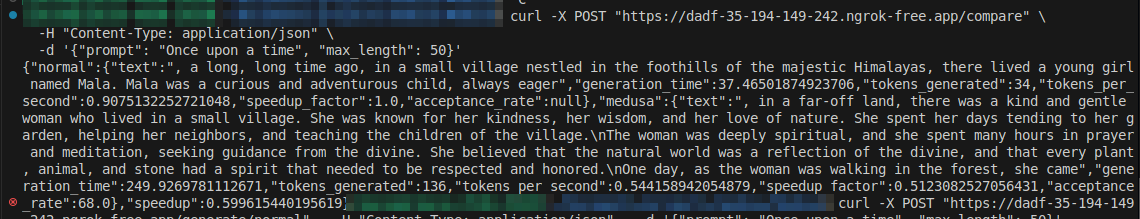



#### Test 2
**Request** 
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/generate/normal" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'

```
**Response**
```
{
  "text": ", a young girl named Lily was born in a small village. She lived a happy life with her parents and siblings, and she loved to help her mother in the kitchen. Lily' 123Movies Movies",
  "generation_time": 40.3927,
  "tokens_generated": 35,
  "tokens_per_second": 0.8665,
  "speedup_factor": 1.0,
  "acceptance_rate": null
}
```
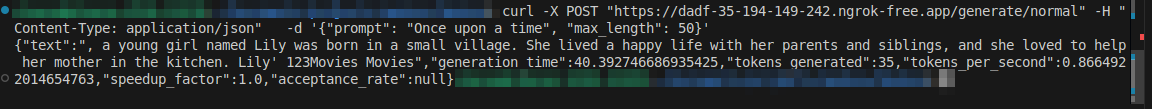



#### Test 3

**Request**
```
curl -X POST "https://dadf-35-194-149-242.ngrok-free.app/generate/medusa" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50
  }'

```

**response**

```
{
  "text": ", in a small village, there lived a kind, old man named John. John was loved by everyone in the village because he was always ready to help those in need. He had a large garden where he grew all kinds of fruits and vegetables. John was known for his delicious apple pies and fruit preserves. People from far and wide came to buy his produce and taste his pies and preserves.\nOne day, a group of travelers passed through the village. They were on their way to a distant land and were hungry. They asked John if he had any food to sell. John told them that he had plenty of food, but he only sold it to people who could pay him in gold or silver coins. The travelers had no coins, but they",
  "generation_time": 263.546,
  "tokens_generated": 163,
  "tokens_per_second": 0.6185,
  "speedup_factor": 0.5823,
  "acceptance_rate": 81.5
}
```

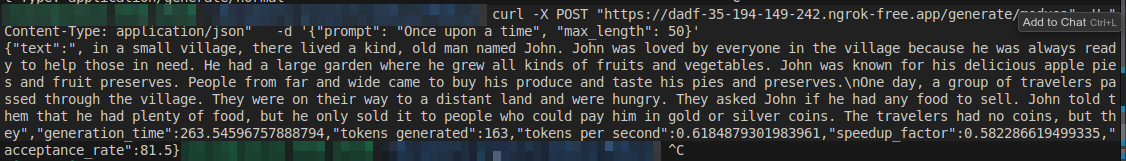


### Testing stretegies documentation

Here are some curl commands to test FastAPI service with Medusa:

### 1. Health Check

```bash
curl -X GET "https://f696-104-196-160-201.ngrok-free.app/health"
```

### 2. Basic Text Generation

```bash
curl -X POST "https://f696-104-196-160-201.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 100,
    "temperature": 0.7,
  }'
```

### 3. Benchmark Comparison (with and without Medusa)

```bash
curl -X POST "https://f696-104-196-160-201.ngrok-free.app/compare" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Once upon a time",
    "max_length": 50,
    "temperature": 0.7,
  }'
```

### 4. Testing with Different Parameters

```bash
# Lower temperature for more deterministic output
curl -X POST "https://f696-104-196-160-201.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Write a poem about",
    "max_length": 100,
    "temperature": 0.3,
  }'

# Higher threshold for more speculative acceptance
curl -X POST "https://f696-104-196-160-201.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Explain quantum physics",
    "max_length": 150,
    "temperature": 0.7,
  }'
```

### 5. Stress Testing with a Complex Prompt

```bash
curl -X POST "https://798e-104-196-160-201.ngrok-free.app/generate" \
  -H "Content-Type: application/json" \
  -d '{
    "prompt": "Write a detailed technical explanation of how speculative decoding works in large language models, including the advantages and potential challenges.",
    "max_length": 200,
    "temperature": 0.7,
  }'

In [9]:
!ngrok authtoken 2rf1753VsPYXTOVl62iLwS2dITs_5XcrdEGFYarW57qMykxj6


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ps aux | grep ngrok


In [ ]:
!kill -9 9675
